In [1]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.03.28
# based on https://github.com/HTuennermann/Vehicle-Detection-and-Tracking

# Overview
- Simple object detector
- Input: RGB image
- Output: cars' locations

# Import libraries

In [2]:
import glob 
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# (1) Data

#### Car images: https://drive.google.com/open?id=1rqitUFrFhB84tFVtg1Ad1TVz6coCWpNZ

In [4]:
cars = glob.glob("./data/obj_detection/vehicles/*/*.png")
non_cars = glob.glob("./data/obj_detection/non-vehicles/*/*.png")

Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars)) - 1])
X = []
for name in cars:    
    X.append(imread(name))
for name in non_cars:    
    X.append(imread(name))
X = np.array(X)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (12432, 64, 64, 3)
12432 train samples
5328 test samples


# (2) Declare model

In [9]:
def get_conv(input_shape=(64, 64, 3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv1', input_shape=input_shape, padding="same"))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (8, 8), activation="relu", name="dense1"))
    model.add(Dropout(0.5))
    model.add(Conv2D(1, (1,1), name="dense2", activation="tanh"))
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 10)        280       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 10)          0         
_________________________________________________________________
dense1 (Conv2D)              (None, 1, 1, 128)         82048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 128)         0         
__________

# (3) Train defined model

In [10]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")

Train on 12432 samples, validate on 5328 samples
Epoch 1/5
12432/12432 [==============================] - 4s 326us/step - loss: 0.5245 - acc: 0.4809 - val_loss: 0.2176 - val_acc: 0.8084
Epoch 2/5
12432/12432 [==============================] - 2s 178us/step - loss: 0.1872 - acc: 0.8473 - val_loss: 0.1455 - val_acc: 0.8941
Epoch 3/5
12432/12432 [==============================] - 2s 176us/step - loss: 0.1301 - acc: 0.8983 - val_loss: 0.0914 - val_acc: 0.9300
Epoch 4/5
12432/12432 [==============================] - 2s 174us/step - loss: 0.1001 - acc: 0.9265 - val_loss: 0.0706 - val_acc: 0.9454
Epoch 5/5
12432/12432 [==============================] - 2s 173us/step - loss: 0.0793 - acc: 0.9391 - val_loss: 0.0642 - val_acc: 0.9523
Test score: 0.06418231131673956
Test accuracy: 0.9523273273273273


# (4) Evaluate trained model

In [11]:
heatmodel = get_conv(input_shape=(None, None, 3), filename="localize.h5")

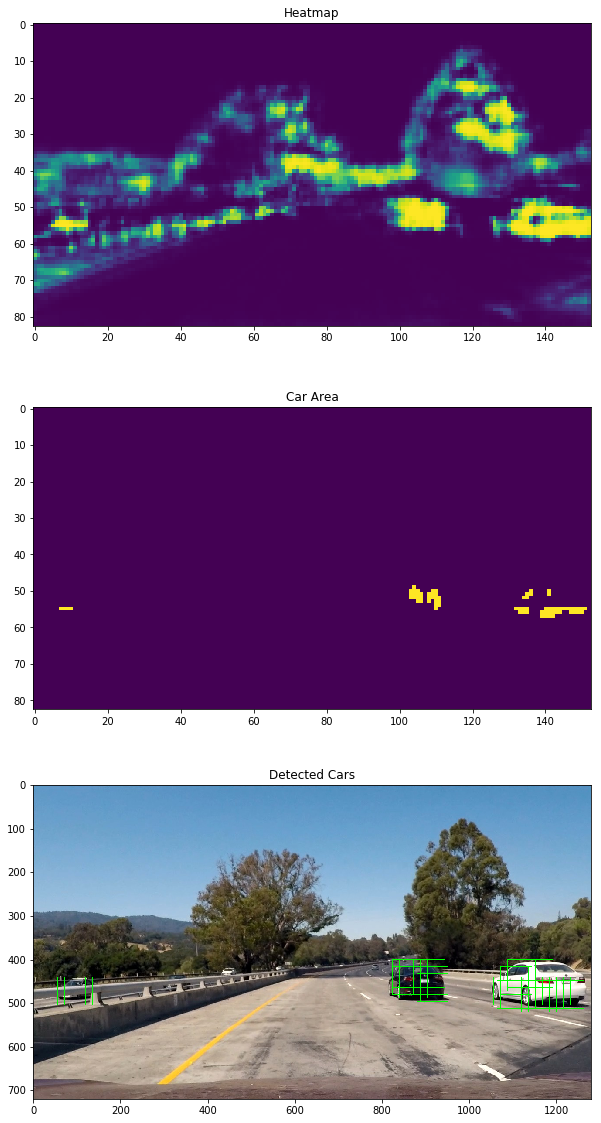

In [17]:
def locate():
    data = imread("test.jpg")
    
    heatmap = heatmodel.predict(data.reshape(1, data.shape[0], data.shape[1], data.shape[2]))
    sel_heatmap = heatmap[0, :, :, 0] > 0.99

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]), np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0, :, :, 0] > 0.99])
    y = (yy[heatmap[0, :, :, 0] > 0.99])
    
    for i, j in zip(x, y):
        data[j*8:j*8+64, i*8] = (0, 255, 0)
        data[j*8:j*8+64, i*8+64] = (0, 255, 0)
        
        data[j*8, i*8:i*8+64] = (0, 255, 0)
        data[j*8+64, i*8:i*8+64] = (0, 255, 0)
    return heatmap[0, :, :, 0], sel_heatmap, data

hm, sel_hm, annotated = locate()

plt.figure(figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.title("Heatmap")
plt.imshow(hm)

plt.subplot(3, 1, 2)
plt.title("Car Area")
plt.imshow(sel_hm)

plt.subplot(3, 1, 3)
plt.title("Detected Cars")
plt.imshow(annotated)
plt.show()